# Actor
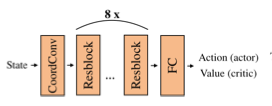

- ResNet-18 used as Feature Extractor
- Use Batch Normalization with ReLU to stabilise Learning
- Use Coord-Conv as first Layer 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weightNorm
from torch.autograd import Variable
import sys

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return (nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False))


##Basic block

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                (nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

##Bottleneck

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = (nn.Conv2d(in_planes, planes, kernel_size=1, bias=False))
        self.conv2 = (nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
        self.conv3 = (nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False))
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                (nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out


##Resnet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_inputs, depth, num_outputs):
        super(ResNet, self).__init__()
        self.in_planes = 64

        block, num_blocks = cfg(depth)

        self.conv1 = conv3x3(num_inputs, 64, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512 * block.expansion, num_outputs)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


In [ ]:
 def cfg(depth):
    depth_lst = [18, 34, 50, 101, 152]
    assert (depth in depth_lst), "Error : Resnet depth should be either 18, 34, 50, 101, 152"
    cf_dict = {
        '18': (BasicBlock, [2,2,2,2]),
        '34': (BasicBlock, [3,4,6,3]),
        '50': (Bottleneck, [3,4,6,3]),
        '101':(Bottleneck, [3,4,23,3]),
        '152':(Bottleneck, [3,8,36,3]),
    }

    return cf_dict[str(depth)]